# Test data process (xyz + uv + normal)

In [3]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))

from data_process.geometry_utils.obj import read_obj

mesh_fp = '../resources/examples/0000/0000.obj'
mesh_obj = read_obj(mesh_fp)

print('*** verts: ', mesh_obj.points.shape, mesh_obj.points.max(axis=0), mesh_obj.points.min(axis=0))
print('*** uvs: ', mesh_obj.point_data['obj:vt'].shape, mesh_obj.point_data['obj:vt'].max(axis=0), mesh_obj.point_data['obj:vt'].min(axis=0))
print('*** normals: ', mesh_obj.point_data['obj:vn'].shape, mesh_obj.point_data['obj:vn'].max(axis=0), mesh_obj.point_data['obj:vn'].min(axis=0))


*** verts:  (143000, 3) [ 459.852 1550.2    229.994] [-458.214  103.119 -196.118]
*** uvs:  (143000, 3) [1431.89 1762.71    0.  ] [-2.96054e+03  2.90294e+02 -5.01000e-06]
*** normals:  (143000, 3) [0.999997 0.998641 0.999999] [-0.999998 -0.999894 -1.      ]


\\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0701\于芮煌\X型正常肩藕节袖叠门襟袖窿公主线分割单向褶无摆有领衬衫领前开门襟 [ 6  6  6  6  7  7  7  7  5  5  4  4  4  4  4  4 11 11 12 12  2  2]
(22, 64, 64, 3) [   0. 1000.    0.] 1000.0
(156, 64, 3) (156, 64, 2)
*** surf_pnts:  [ 429.12918 1552.3402   195.33504] [-430.3999    0.     -182.2228]
*** edge_pnts:  [ 425.351   1544.04     195.55554] [-426.65402  723.4055  -182.77979]
*** uv_offset:  (1, 2) [   0. 1000.] [   0. 1000.]
(22, 4) (22, 2) (22, 2)
[_to_o3d_pc] color:  std::vector<Eigen::Vector3d> with 90112 elements.
Use numpy.asarray() to access data.
[_to_o3d_pc] color:  std::vector<Eigen::Vector3d> with 9984 elements.
Use numpy.asarray() to access data.
(22, 2) (22, 2) 22


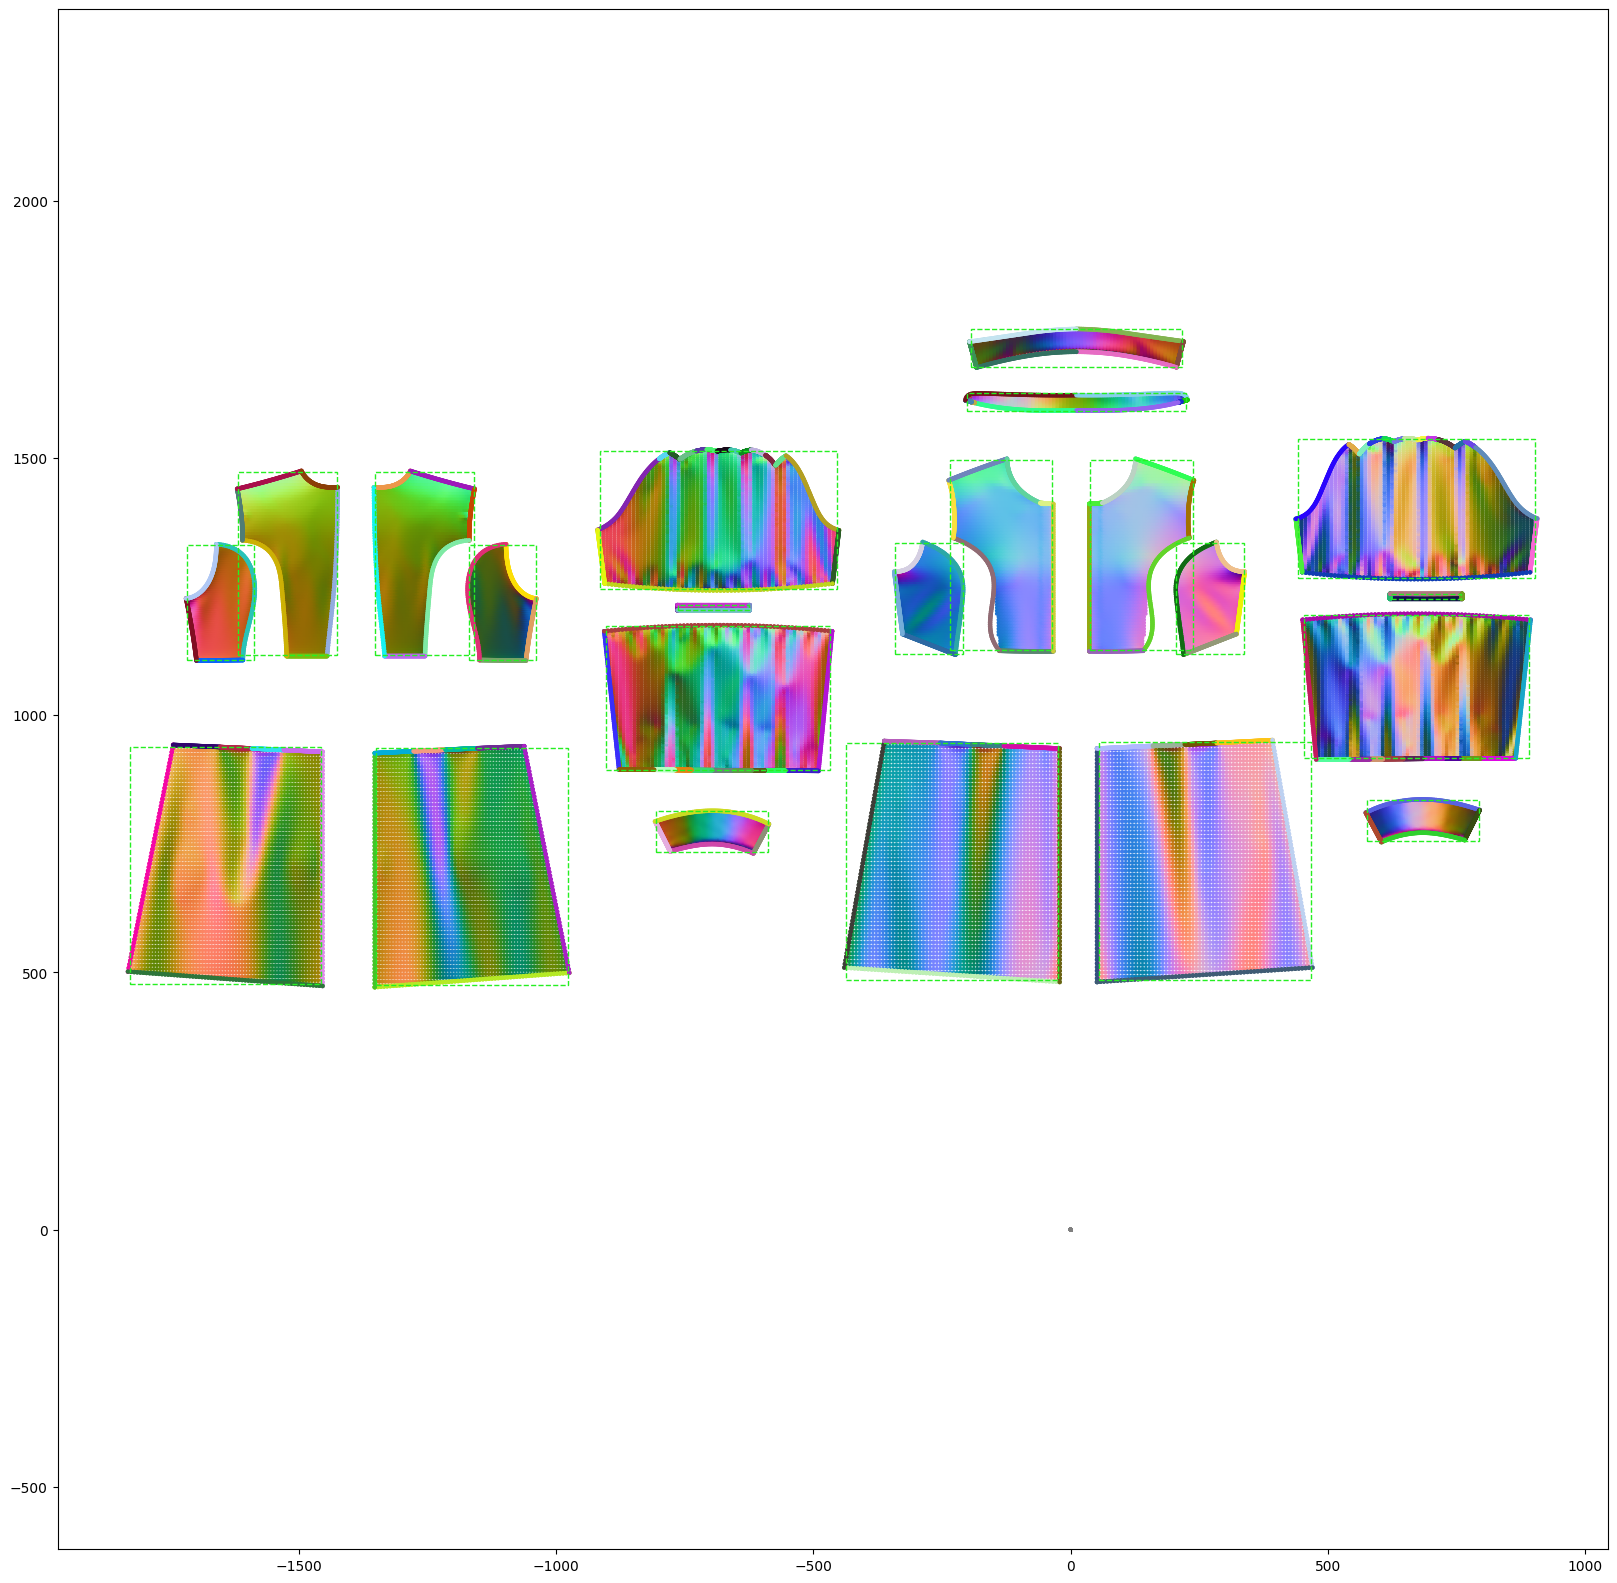

In [56]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 
from matplotlib.colors import to_rgb


from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#696969"},
    "木耳边": {"alias": "木耳边", "color": "#696969"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#696969"},
    "荷叶边": {"alias": "荷叶边", "color": "#696969"},
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']


def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd

def _draw_bboxes_2d(ax, bboxes_min, bboxes_max, color='r'):
    
    num_points = bboxes_min.shape[0]
    print(bboxes_min.shape, bboxes_max.shape, num_points)
    
    for idx in range(num_points):
        p0_ = bboxes_min[idx]
        p1_ = bboxes_max[idx]
        
        # Extract coordinates
        x0, y0 = p0_
        x1, y1 = p1_
        
        # Calculate width and height of the bounding box
        width = x1 - x0
        height = y1 - y0
        
        # Create a rectangle patch
        rect = patches.Rectangle((x0, y0), width, height, linestyle='--', linewidth=1, edgecolor=color, facecolor='none')
        
        # Add the rectangle to the plot
        ax.add_patch(rect)
    
    
    
data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\"
data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))

with open(data_path, "rb") as tf: data = pickle.load(tf)

print(data['data_fp'], data['surf_cls'])
print(data['surf_wcs'].shape, data['global_offset'], data['global_scale'])
print(data['edge_wcs'].shape, data['edge_uv_wcs'].shape)

global_offset = np.array(data['global_offset'])[None]
global_scale = data['global_scale']

uv_offset = data['uv_offset'][None]
uv_scale = data['uv_scale']

surf_pnts = data['surf_mask'].reshape(-1, 1) * (data['surf_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset)
edge_pnts = data['edge_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset

print('*** surf_pnts: ', surf_pnts.max(axis=0), surf_pnts.min(axis=0))
print('*** edge_pnts: ', edge_pnts.max(axis=0), edge_pnts.min(axis=0))
print('*** uv_offset: ', uv_offset.shape, uv_offset.max(axis=0), uv_offset.min(axis=0))

surf_uv = data['surf_mask'].reshape(-1, 1) * (data['surf_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset)
edge_uv = data['edge_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset

surf_bbox_min = data['surf_bbox_wcs'][:, :3] * (global_scale * 0.5) + global_offset
surf_bbox_max = data['surf_bbox_wcs'][:, 3:] * (global_scale * 0.5) + global_offset

surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2] * (uv_scale * 0.5) + uv_offset
surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:] * (uv_scale * 0.5) + uv_offset

surf_color = np.random.rand(3)

print(data['surf_uv_bbox_wcs'].shape, surf_uv_bbox_min.shape, surf_uv_bbox_max.shape)

surf_colors = ((data['surf_normals'].reshape(-1, 3) + 1.0) * 0.5).clip(0, 1)
edge_colors = np.expand_dims(np.random.rand(data['edge_uv_wcs'].shape[0], 3), axis=1).repeat(data['edge_uv_wcs'].shape[1], axis=1).reshape(-1, 3)

surf_pcd = _to_o3d_pc(surf_pnts, surf_colors)
edge_pcd = _to_o3d_pc(edge_pnts, edge_colors)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.scatter(surf_uv[:, 0], surf_uv[:, 1], c=surf_colors, s=3.5)
ax.scatter(edge_uv[:, 0], edge_uv[:, 1], c=edge_colors, s=5)
ax.scatter(edge_uv[:, 0], edge_uv[:, 1], c=edge_colors, s=5)

_draw_bboxes_2d(ax, surf_uv_bbox_min, surf_uv_bbox_max, color=surf_color)

# plt.axis('off')
plt.axis('equal')
plt.show()

bboxes_3d = []
for idx in range(surf_bbox_min.shape[0]):
    bboxes_3d.append(o3d.geometry.AxisAlignedBoundingBox(surf_bbox_min[idx][..., None], surf_bbox_max[idx][..., None]))
    bboxes_3d[-1].color = to_rgb(_CMAP[_PANEL_CLS[data['surf_cls'][idx]-1]]['color'])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([surf_pcd, edge_pcd, mesh_frame] + bboxes_3d)

*** all_items:  100 ['E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\2645.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\8669.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\3787.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\2061.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\5105.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\9833.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\3323.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\3677.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\5675.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\0743.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\9065.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\8681.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\5224.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\10716.pkl', 'E:\\lry\\data\\AIGP\\demo

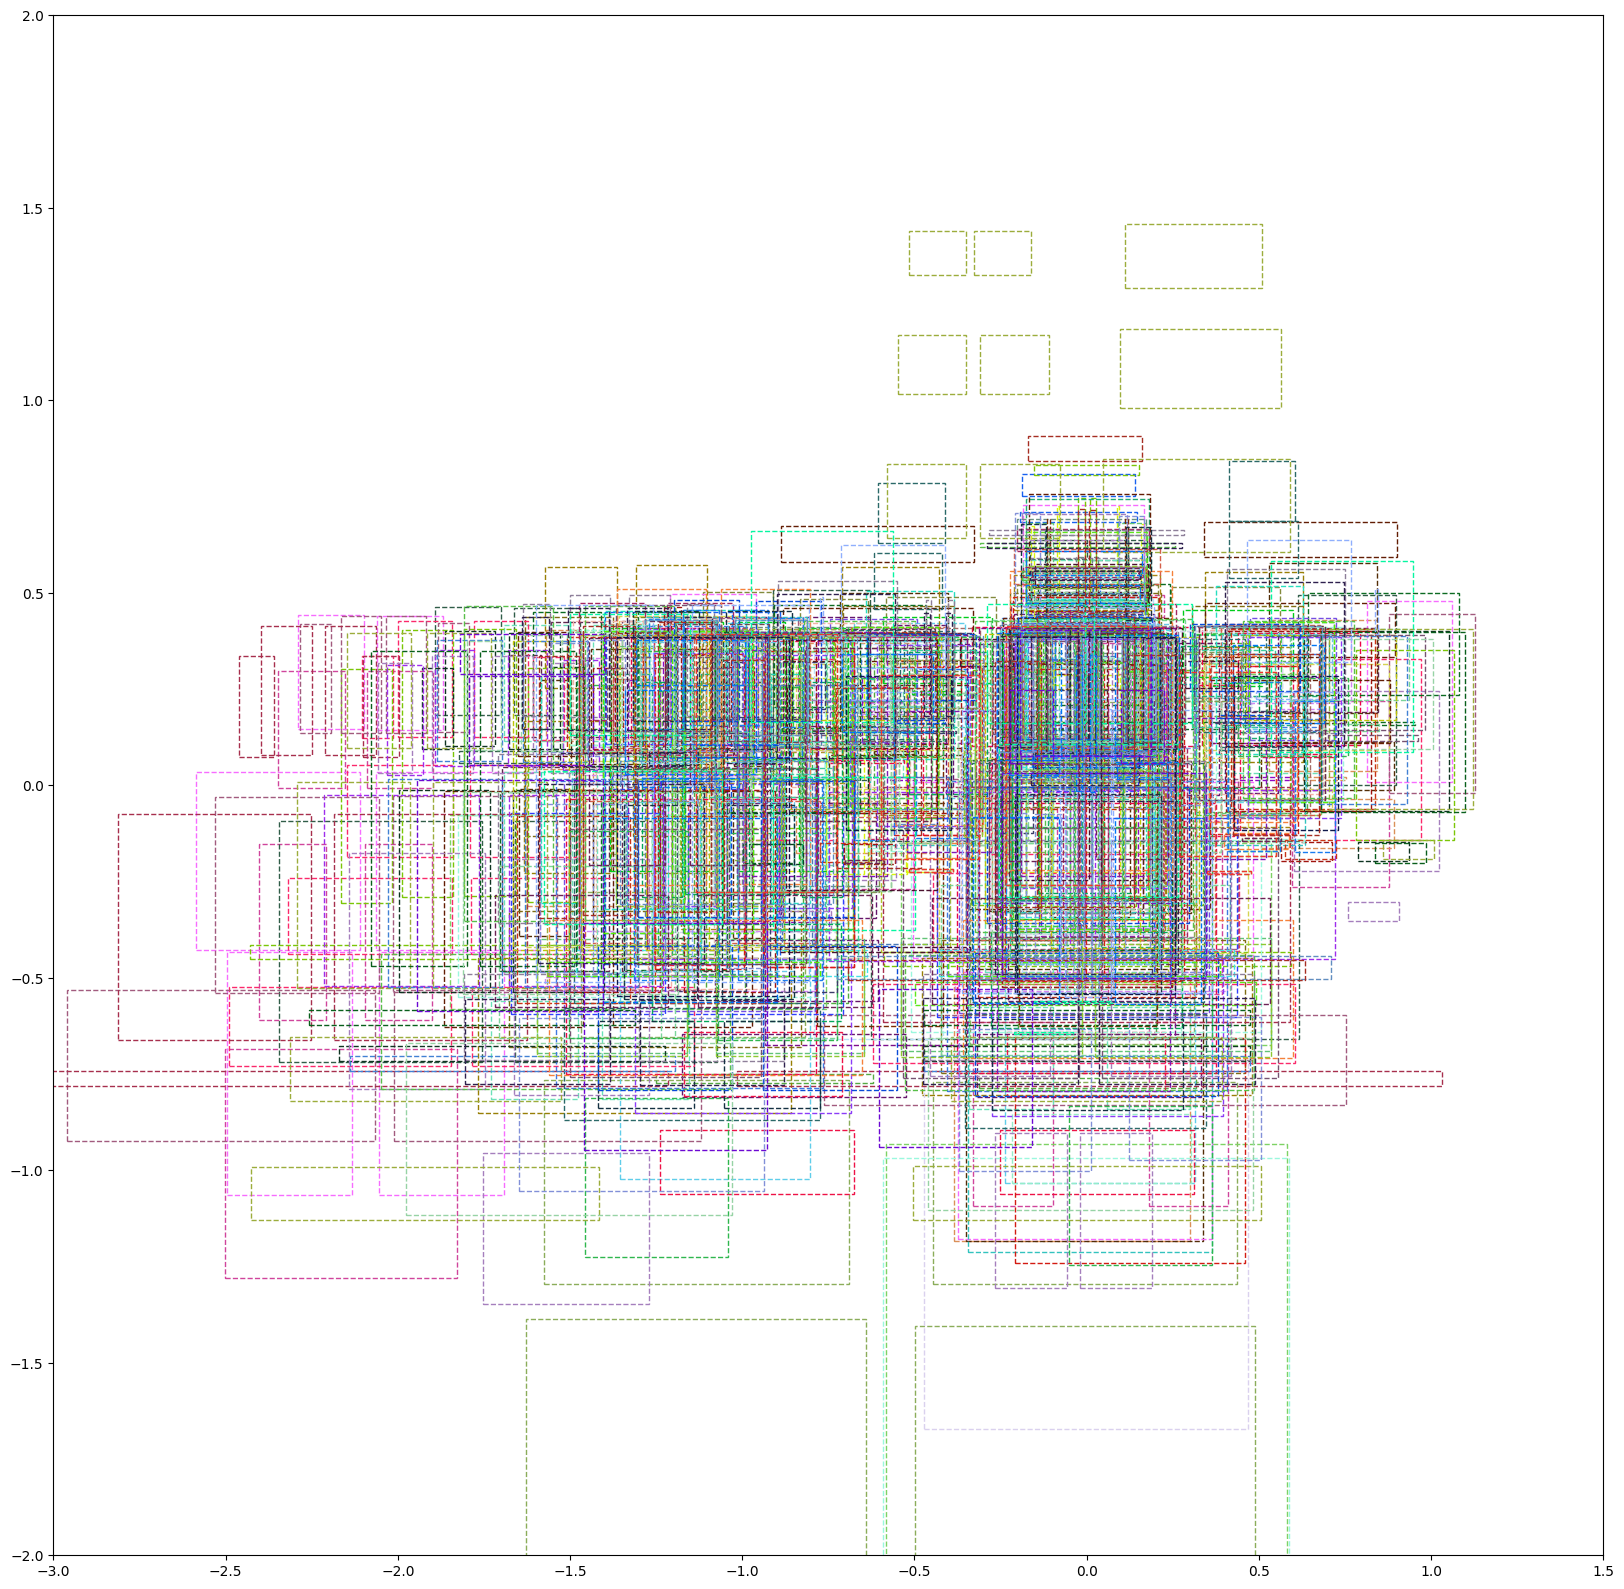

In [58]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 

from glob import glob

def _draw_bboxes_2d(ax, bboxes_min, bboxes_max, color='r', cmap=None):
    num_points = bboxes_min.shape[0]
    for idx in range(num_points):
        p0_ = bboxes_min[idx]
        p1_ = bboxes_max[idx]
        
        # Extract coordinates
        x0, y0 = p0_
        x1, y1 = p1_
        
        # Calculate width and height of the bounding box
        width = x1 - x0
        height = y1 - y0
        # Create a rectangle patch
        rect = patches.Rectangle(
            (x0, y0), width, height, linestyle='--', linewidth=1, 
            edgecolor=color if cmap is None else cmap[idx], facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)
        

data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_new_single_norm\\"
all_items = random.choices(glob(os.path.join(data_root, '*.pkl')), k=100)

print('*** all_items: ', len(all_items), all_items)

surf_bboxes = []
surf_uv_bboxes = []

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

ax.set_xlim(-3, 1.5)
ax.set_ylim(-2, 2)

for data_item in all_items:
    with open(data_item, "rb") as tf: data = pickle.load(tf)
    
    uv_scale = data['uv_scale']
    uv_offset = data['uv_offset']
    
    # print(uv_scale, uv_offset)
    
    surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2]
    surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:]
    surf_color = np.random.rand(3)
    
    # print(surf_bbox_max.shape, surf_bbox_max.max(), surf_bbox_min.shape, surf_bbox_min.min())
        
    _draw_bboxes_2d(ax, surf_uv_bbox_min, surf_uv_bbox_max, color=surf_color)    

plt.show()